In [1]:
if "running_all" not in globals():
    from ipywidgets import widgets
    matrices = ["bcsstk18", "cbuckle", "ct20stif", "raefsky4", "vanbody"]
    b = widgets.Button(description="Run over all matrices", button_style="success")
    output = widgets.Output()

    display(b, output)

    def run_over_all_matrices(button):
        global running_all
        global matrix
        running_all = True
        with output:
            for matrix in matrices:
                print(f"Running {matrix}...")
                %run ./overhead_analysis.ipynb # will output at this cell rather than later
            print("Finished!")
    b.on_click(run_over_all_matrices)

Button(button_style='success', description='Run over all matrices', style=ButtonStyle())

Output()

In [2]:
if "running_all" not in globals():
    matrix = "bcircuit"  # manually set to run over one matrix
matrix

'bcircuit'

In [3]:
from scipy.sparse.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from io_utils import load_models, load_matrices_from_dir

  Activating project at `~/My_Drive/Research/code/Dynamic-Selective-Protection/Pcg`


In [4]:
test_data_sizes = {
    "bcsstk18": 1000,
    "cbuckle": 1000,
    "ct20stif": 1000,
    "raefsky4": 1000,
    "vanbody": 100,
    "Pres_Poisson": 1000,
    "Na5": 1000,
    "bcircuit": 1000,
}

ylims = {
    "bcsstk18": (0.2, 1.5),
    "cbuckle": (0, 1.5),
    "ct20stif": (0, 1.5),
    "raefsky4": (0, 0.2),
    "vanbody": (0.8, 1.5),
    "Pres_Poisson": (0, 0.6),
    "Na5": (0, 1.5),
    "bcircuit": (0, 1.5),
}

df = pd.read_csv(f"data/{matrix}_{test_data_sizes[matrix]}.csv")
errorfree_iterations = df["errorfree_iterations"][0]  # all the same
n_rows = df["n_rows"][0]  # all the same
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,bcircuit.mat,48,0.000001,4800,19468,31,41,8.511686e-07,True,0.095583,0.503071,68902,0.854167
1,bcircuit.mat,48,0.000001,4800,21329,34,47,9.993444e-07,True,0.109453,0.445820,68902,0.979167
2,bcircuit.mat,48,0.000001,4800,8393,47,120,9.675828e-07,True,0.243944,72.526651,68902,2.500000
3,bcircuit.mat,48,0.000001,4800,15359,0,66,8.734661e-07,True,0.153866,276.799212,68902,1.375000
4,bcircuit.mat,48,0.000001,4800,62795,14,58,8.709925e-07,True,0.137443,0.045752,68902,1.208333


In [5]:
chosen_models = {
    "bcsstk18": "XGBRegressor",
    "cbuckle": "RandomForestRegressor",
    "ct20stif": "XGBRegressor",
    "raefsky4": "RandomForestRegressor",
    "vanbody": "KNeighborsRegressor",
    "Pres_Poisson": "XGBRegressor",
    "Na5": "XGBRegressor",
    "bcircuit": "XGBRegressor",
}

model_path = f"./models/{matrix}/best_{chosen_models[matrix]}.pkl"
model = load_models([model_path])[0]
model

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09515780413625062, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=741, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [6]:
X = df[["error_iter", "pos_2norm"]].to_numpy()
df["prot_score"] = model.predict(X)
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown,prot_score
0,bcircuit.mat,48,0.000001,4800,19468,31,41,8.511686e-07,True,0.095583,0.503071,68902,0.854167,0.420991
1,bcircuit.mat,48,0.000001,4800,21329,34,47,9.993444e-07,True,0.109453,0.445820,68902,0.979167,1.009688
2,bcircuit.mat,48,0.000001,4800,8393,47,120,9.675828e-07,True,0.243944,72.526651,68902,2.500000,2.905460
3,bcircuit.mat,48,0.000001,4800,15359,0,66,8.734661e-07,True,0.153866,276.799212,68902,1.375000,0.668591
4,bcircuit.mat,48,0.000001,4800,62795,14,58,8.709925e-07,True,0.137443,0.045752,68902,1.208333,1.079924


In [7]:
mats = load_matrices_from_dir("../matrices/raw", subset=[matrix])
mat = list(mats.values())[0]
mat

<68902x68902 sparse matrix of type '<class 'numpy.float64'>'
	with 375558 stored elements in Compressed Sparse Column format>

In [8]:
pos_2norms = {pos: norm(mat.getrow(pos)) for pos in range(mat.shape[0])}
iter_norm_pairs = np.array([[i, pos_2norms[pos], pos] for pos in range(mat.shape[0])
                            for i in range(errorfree_iterations)])
df_preds = pd.DataFrame(iter_norm_pairs, columns=["i", "2norm", "rowid"])
df_preds["output"] = model.predict(df_preds[["i", "2norm"]].to_numpy())
df_preds_piv = df_preds.pivot(index=["2norm", "rowid"], columns="i", values="output")
prot_scores = df_preds_piv.to_numpy().T
df_preds_piv.head()

i                     0.0       1.0       2.0       3.0       4.0       5.0   \
2norm    rowid                                                                 
0.000038 67284.0  0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         65529.0  0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         65679.0  0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         67434.0  0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   
         65499.0  0.593026  0.650109  0.866802  0.759093  0.684858  0.906884   

i                     6.0       7.0       8.0       9.0   ...     38.0  \
2norm    rowid                                            ...            
0.000038 67284.0  0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         65529.0  0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         65679.0  0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         67434.0  0.636505  0.565855  1.083345  0.758954  ...  1.06585   
         65499.0  0.636505  0.565855  1.083345  0.758954  ...  1.06585   

i                     39.0      40.0      41.0      42.0      43.0      44.0  \
2norm    rowid                                                                 
0.000038 67284.0  1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         65529.0  1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         65679.0  1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         67434.0  1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   
         65499.0  1.566306  1.008087  1.008087  1.044009  1.044009  0.901004   

i                     45.0      46.0      47.0  
2norm    rowid                                  
0.000038 67284.0  1.107859  1.095914  1.067039  
         65529.0  1.107859  1.095914  1.067039  
         65679.0  1.107859  1.095914  1.067039  
         67434.0  1.107859  1.095914  1.067039  
         65499.0  1.107859  1.095914  1.067039  

[5 rows x 48 columns]

In [9]:
ps = list(np.arange(1 / 98, 1.01, 0.01))
percentages = np.arange(0.01, 1.0, 0.01)
nonerror_runs_by_p = {p: int((len(df) / p) - len(df)) for p in ps}
max_nonerror_runs = int((len(df) / min(ps)) - len(df))
solve_iterations = np.append(df["solve_iterations"], [errorfree_iterations] * max_nonerror_runs)
slowdowns = np.append(df["slowdown"], [1] * max_nonerror_runs)
errorfree_op_count = errorfree_iterations * n_rows

In [10]:
def compute_overheads(error_iterations, n_protections):
    return ((error_iterations * n_rows + n_protections) - errorfree_op_count) / errorfree_op_count

def protect(error_iterations, protections):
    return np.vectorize(lambda i: error_iterations[i] if not protections[i]
                        else errorfree_iterations)(range(len(error_iterations)))

def make_p_overhead_dataframe(ohs_by_p):
    return pd.concat([pd.DataFrame({"p": [ps[i]] * len(os), "overhead": os})
                         for i, os in enumerate(ohs_by_p)], ignore_index=True)

In [11]:
nonprot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    nonprot_overheads = compute_overheads(solve_iterations[:data_size], 0)
    nonprot_overheads_by_p.append(nonprot_overheads)

nonprot_df = make_p_overhead_dataframe(nonprot_overheads_by_p)

In [12]:
prot_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    # for the purpose of choosing solve_iterations or errorfree_iterations, did_protect will
    # always be False for nonerror runs, but this is fine because n_protections is computed
    # later for the purposes of calculating overhead
    protections = np.append(df["prot_score"] > (1 + (1 / p)), [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = (prot_scores > (1 + (1 / p))).sum()

    prot_overheads = compute_overheads(prot_iterations, n_protections)
    prot_overheads_by_p.append(prot_overheads)

prot_df = make_p_overhead_dataframe(prot_overheads_by_p)

In [13]:
random_overheads = []
for perc in percentages:
    protections = np.random.rand(len(df)) < perc
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = int(errorfree_iterations * n_rows * perc)
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    random_overheads.append(prot_overheads.mean())
    
best_random_percentage = percentages[np.argmin(random_overheads)]
rand_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)
    
    protections = np.random.rand(data_size) < best_random_percentage

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = int(errorfree_iterations * n_rows * best_random_percentage)
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    rand_overheads_by_p.append(prot_overheads)

rand_df = make_p_overhead_dataframe(rand_overheads_by_p)

In [14]:
r2ns = np.array(list(pos_2norms.values()))
r2n_overheads = []
for perc in percentages:
    cutoff = np.quantile(r2ns, 1 - perc)
    protections = df["pos_2norm"] >= cutoff
    prot_iterations = protect(solve_iterations[:len(df)], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads.append(prot_overheads.mean())

best_r2n_percentage = percentages[np.argmin(r2n_overheads)]
cutoff = np.quantile(r2ns, 1 - best_r2n_percentage)
r2n_overheads_by_p = []

for p in ps:
    # need to pad dataset to add non-error runs
    n_nonerror_runs = nonerror_runs_by_p[p]
    data_size = n_nonerror_runs + len(df)

    protections = np.append(df["pos_2norm"] >= cutoff, [False] * n_nonerror_runs)

    prot_iterations = protect(solve_iterations[:data_size], protections)
    n_protections = errorfree_iterations * (r2ns >= cutoff).sum()
    
    prot_overheads = compute_overheads(prot_iterations, n_protections)
    r2n_overheads_by_p.append(prot_overheads)

r2n_df = make_p_overhead_dataframe(r2n_overheads_by_p)

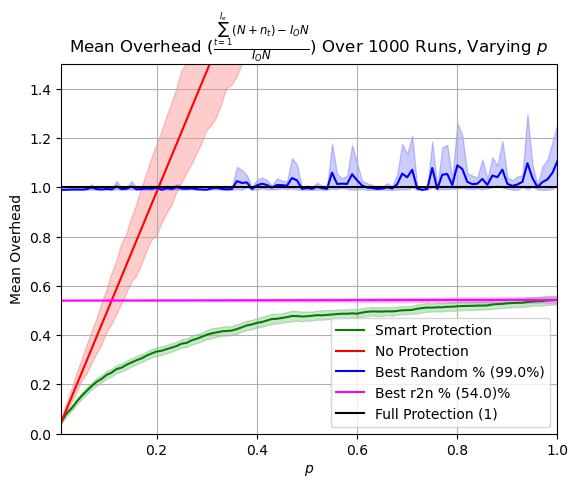

In [15]:
sns.lineplot(prot_df, x="p", y="overhead",
         label="Smart Protection", c="green")
sns.lineplot(nonprot_df, x="p", y="overhead",
             label="No Protection", c="red")
sns.lineplot(rand_df, x="p", y="overhead",
             label=f"Best Random % ({best_random_percentage * 100}%)", c="blue")
sns.lineplot(r2n_df, x="p", y="overhead",
             label=f"Best r2n % ({best_r2n_percentage * 100})%", c="magenta")
plt.plot(ps, [1] * len(ps), label="Full Protection (1)", c="black")

plt.xlabel("$p$")
plt.ylabel("Mean Overhead")
overhead_formula = r"$ \frac{\sum_{t=1}^{I_e}(N + n_t) - I_ON}{I_ON} $"
plt.title(f"Mean Overhead ({overhead_formula}) Over 1000 Runs, Varying $p$ ")
plt.legend()
plt.grid()
plt.xlim(0.01, 1)
plt.ylim(*ylims[matrix])
plt.savefig(f"./figures/{matrix}/mean_overheads.png")
plt.show()

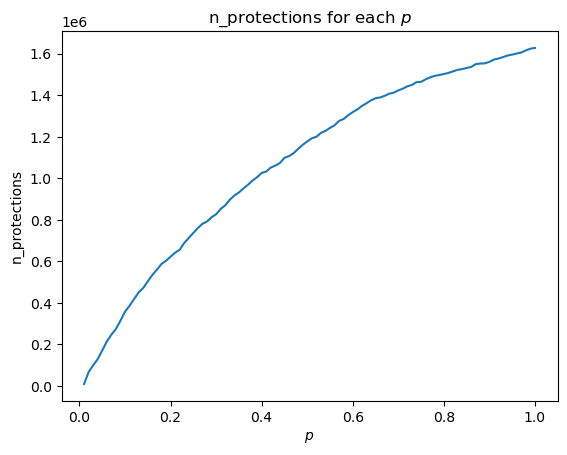

In [16]:
n_prots_per_p = []

for p in ps:
    protections = prot_scores > (1 + (1 / p))
    n_prots_per_p.append(protections.sum())

s = pd.Series(n_prots_per_p)
plt.plot(ps, s)
plt.title("n_protections for each $p$")
plt.xlabel("$p$")
plt.ylabel("n_protections")
plt.show()